In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from belief_tree import Tree

### Initialise the agent

In [2]:
def policy(q_values, temp=None, policy_type='softmax'):

    '''
    ----
    Agent's policy

    q_values -- q values at the current state
    temp     -- inverse temperature
    type     -- softmax / greeedy
    ----
    '''

    if np.all(q_values == 0):
        return np.array([0.5, 0.5])

    if temp:
        t = temp
    else:
        t = 1
        
    if policy_type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    elif policy_type == 'greedy':
        return np.array(q_values >= q_values.max()).astype(int)
    else:
        raise KeyError('Unknown policy type')

In [ ]:
M = np.array([
    [29, 1],
    [1, 1]
])

gamma = 0.9
xi    = 0.0

Q = np.zeros(2)

tree = Tree(M, Q, 1, 'greedy')

### Full Bayesian updates

In [ ]:
horizon = 3
tree.root_q_values = Q
tree.build_tree(horizon)
tree.full_updates(gamma)

In [ ]:
qval_tree = tree.qval_tree
qval_tree[0][(0, 0, 0)]

### Replay

In [ ]:
horizon = 3
tree.root_q_values = Q
tree.build_tree(horizon)
qval_history, need_history, replays = tree.replay_updates(gamma, xi)

In [ ]:
qval_tree = tree.qval_tree
qval_tree[0][(0, 0, 0)]

### Generate replay tree

In [ ]:
from tex_tree import generate_big_tex_tree

save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/example_tree/seq/'
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
    os.mkdir(save_folder)
else:
    os.makedirs(save_folder)

for idx, rep in enumerate(replays):
    these_replays = replays[:idx+1]
    save_path = os.path.join(save_folder, 'tex_tree_%u.tex'%idx)
    generate_big_tex_tree(horizon, these_replays, qval_history[idx], need_history[idx], save_path)

### Distribution updates asymmetry 

In [ ]:
from scipy.stats import beta
from scipy.special import kl_div

In [ ]:
x = np.linspace(0.001, 1, 100)

a1b, b1b = np.array([2, 1])
rv1b = beta(a1b, b1b)  

a1a, b1a = np.array([3, 1])
rv1a = beta(a1a, b1a)

a1aa, b1aa = np.array([4, 1])
rv1aa = beta(a1aa, b1aa)

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(x, rv1b.pdf(x))
plt.title(r'$\alpha=2, \beta=1$')

plt.subplot(132)
plt.plot(x, rv1a.pdf(x))
plt.title(r'$\alpha=3, \beta=1$')

print(np.sum(kl_div(rv1b.pdf(x), rv1a.pdf(x))))

plt.subplot(133)
plt.plot(x, rv1aa.pdf(x))
plt.title(r'$\alpha=4, \beta=1$')

print(np.sum(kl_div(rv1a.pdf(x), rv1aa.pdf(x))))

plt.tight_layout()

# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/betas.png')

### Number of replays until convergence

In [ ]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/bandit/data/convergence/num_replays/'

# vary these parameters
alphas_0 = np.arange(1, 40)
betas_0  = np.arange(1, 40)

# constant parameters
alpha_1 = 1
beta_1  = 1

gamma   = 0.9
temp    = 1
xi      = 0.1

save_figures_path = os.path.join(save_folder, 'temp%u'%temp)
save_data_path    = os.path.join(save_folder, 'data', 'temp%u'%temp)

if not os.path.isdir(save_figures_path):
    os.makedirs(save_figures_path)
    os.makedirs(save_data_path)

for horizon in [3, 4, 5]:

    R_true = np.full((len(alphas_0), len(betas_0)), np.nan)
    R      = np.full((len(alphas_0), len(betas_0)), np.nan)
    N      = np.full((len(alphas_0), len(betas_0)), np.nan)

    for alpha_0 in alphas_0:
        for beta_0 in betas_0:
            
            # prior belie at the root
            M = np.array([
                [alpha_0, beta_0],
                [alpha_1, beta_1],
            ])

            # MF Q values at the root
            Q    = np.zeros(2)

            # initialise the agent
            tree = Tree(M, Q, temp, 'softmax')

            # build the tree
            tree.build_tree(horizon)
            
            # do full bayesian updates
            tree.full_updates(gamma)
            qval_tree = tree.qval_tree
            qvals     = qval_tree[0][(0, 0, 0)]
            print(r'$\alpha_0=%u, \beta_0=%u$'%(alpha_0, beta_0))
            v_full = np.max(qvals)
            
            # do replay
            tree.root_q_values = np.zeros(2)
            qval_history, need_history, replays = tree.replay_updates(gamma, xi)
            qval_tree = qval_history[-1]
            qvals     = qval_tree[0][(0, 0, 0)]
            v_replay  = np.dot(policy(qvals, temp=temp), qvals)

            R_true[alpha_0-alphas_0[0], beta_0-betas_0[0]] = v_full
            R[alpha_0-alphas_0[0], beta_0-betas_0[0]]      = v_replay
            N[alpha_0-alphas_0[0], beta_0-betas_0[0]]      = len(qval_history) - 1

    file_name = 'value_horizon%u_alpha%u_beta%u_xi%s_temp%u'%(horizon-1, alpha_1, beta_1, ''.join(str(xi).split('.')), temp)
    np.save(os.path.join(save_data_path, file_name + '.npy'), R)
    fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
    plt.pcolormesh(R, vmax=np.nanmax(R))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Root value', rotation=270, fontsize=14, labelpad=18)
    plt.xlabel(r'$\beta_0$', fontsize=14)
    plt.xticks(range(R.shape[0]), range(1, R.shape[0]+1))
    plt.ylabel(r'$\alpha_0$', fontsize=14)
    plt.yticks(range(R.shape[1]), range(1, R.shape[1]+1))
    plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)
    plt.savefig(os.path.join(save_figures_path, file_name + '.png'))
    plt.close()

    diff      = R_true - R
    file_name = 'value_diff_horizon%u_alpha%u_beta%u_xi%s_temp%u'%(horizon-1, alpha_1, beta_1, ''.join(str(xi).split('.')), temp)
    np.save(os.path.join(save_data_path, file_name + '.npy'), diff)
    fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
    plt.pcolormesh(diff, vmax=np.nanmax(diff))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('delta root value', rotation=270, fontsize=14, labelpad=18)
    plt.xlabel(r'$\beta_0$', fontsize=14)
    plt.xticks(range(R.shape[0]), range(1, R.shape[0]+1))
    plt.ylabel(r'$\alpha_0$', fontsize=14)
    plt.yticks(range(R.shape[1]), range(1, R.shape[1]+1))
    plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)
    plt.savefig(os.path.join(save_figures_path, file_name + '.png'))
    plt.close()

    file_name = 'num_horizon%u_alpha%u_beta%u_xi%s_temp%u'%(horizon-1, alpha_1, beta_1, ''.join(str(xi).split('.')), temp)
    np.save(os.path.join(save_data_path, file_name + '.npy'), N)
    fig = plt.figure(figsize=(10, 8), dpi=100, constrained_layout=True)
    plt.pcolormesh(N, vmax=np.nanmax(N))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Number of replays', rotation=270, fontsize=14, labelpad=18)
    plt.xlabel(r'$\beta_0$', fontsize=14)
    plt.xticks(range(R.shape[0]), range(1, R.shape[0]+1))
    plt.ylabel(r'$\alpha_0$', fontsize=14)
    plt.yticks(range(R.shape[1]), range(1, R.shape[1]+1))
    plt.title(r'$\alpha_1=%u, \beta_1=%u$'%(alpha_1, beta_1), fontsize=18)
    plt.savefig(os.path.join(save_figures_path, file_name + '.png'))
    plt.close()

    print('Done with horizon %u'%horizon)

### Replay threshold and value convergence

In [ ]:
save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/rldm/figures/fig1/betas'

# vary these parameters
xis       = np.append(0, np.logspace(np.log2(0.001), np.log2(1.0), 18, base=2))
horizons  = [2, 3, 4, 5]
betas     = [0.1, 0.5, 1, 2, 4, 8]

# constant parameters
alpha_0 = 5
beta_0  = 1
alpha_1 = 1
beta_1  = 1

gamma   = 0.9

# prior belie at the root
M = np.array([
    [alpha_0, beta_0],
    [alpha_1, beta_1],
], dtype=int)

# MF Q values at the root
Q    = np.zeros(2)

# store results here
R      = np.zeros((len(horizons), len(betas), len(xis)))
nreps  = np.zeros((len(horizons), len(betas), len(xis)), dtype=int)
R_true = np.zeros(len(horizons))

for hidx, horizon in enumerate(horizons):
            
    # initialise the agent
    tree = Tree(M, Q, 1, 'softmax')
    tree.build_tree(horizon)
    
    # do full bayesian updates
    tree.full_updates(gamma)
    qval_tree    = tree.qval_tree
    qvals        = qval_tree[0][(0, 0, 0)]
    v_full       = np.max(qvals)
    R_true[hidx] = v_full
    
    for bidx, beta in enumerate(betas):

        # initialise the agent
        tree = Tree(M, Q, beta, 'softmax')

        for xidx, xi in enumerate(xis):

            tree.build_tree(horizon)
            # do replay
            qval_history, need_history, replays = tree.replay_updates(gamma, xi)
            qvals     = tree.qval_tree[0][(0, 0, 0)]
            v_replay  = np.dot(policy(qvals, temp=beta), qvals)
            R[hidx, bidx, xidx]     = v_replay
            nreps[hidx, bidx, xidx] = len(replays)-1

    print('Horizon %u'%horizon)

fig, axes = plt.subplots(4, 2, figsize=(14, 18), dpi=100, constrained_layout=True, gridspec_kw={'height_ratios':[2, 1, 2, 1]})
plt.suptitle('$alpha0 = %u, beta0 = %u, alpha1 = %u, beta1 = %u'%(alpha_0, beta_0, alpha_1, beta_1), fontsize=14)

for hidx, h in enumerate(horizons):

    if (hidx == 0) or (hidx == 1): 
        axv = axes[0, hidx%2]
        axr = axes[1, hidx%2]
    else:
        axv = axes[2, hidx%2]
        axr = axes[3, hidx%2]

    for bidx, beta in enumerate(betas): 
        
        axv.plot(R[hidx, bidx, ::-1], label='Beta %.1f'%beta)
        axv.scatter(range(len(xis)), R[hidx, bidx, ::-1])
        
        axr.plot(nreps[hidx, bidx, ::-1], label='Beta %.1f'%beta)
        axr.scatter(range(len(xis)), nreps[hidx, bidx, ::-1])

        if bidx == (len(betas) - 1):

            axv.axhline(R_true[hidx], linestyle='--', color='k', alpha=0.7, label='Optimal value')
        
            axv.legend(prop={'size': 9})
            axr.legend(prop={'size': 9})

            axv.set_ylabel('Root value', fontsize=12)
            axv.set_ylim(0, np.max(R_true)+0.05)

            axr.set_ylabel('Number of replays', fontsize=12)
            # axr.set_ylim(0, np.nanmax(nreps)+1)

            axv.set_title('Horizon %u'%(h-1), fontsize=13)

            axr.set_xlabel(r'$\xi$', fontsize=12)
            axr.set_xticks(range(R.shape[2]), ['%.4f'%i for i in xis[::-1]], rotation=60)

            axv.set_xticks([])

file_name = 'alpha0%u_beta0%u_alpha1%u_beta1%u_complete'%(alpha_0, beta_0, alpha_1, beta_1)
np.save(os.path.join(save_folder, 'data', file_name + '.npy'), R)
plt.savefig(os.path.join(save_folder, file_name + '.png'))

plt.close()

### Evaluated policy

In [24]:
import pickle

In [62]:
# save path
root_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits'
save_path   = os.path.join(root_folder, 'rldm/figures/fig1/trees/2')
    
with open(os.path.join(save_path, 'tree.pkl'), 'rb') as f:
    tree = pickle.load(f)

qval_history = np.load(os.path.join(save_path, 'qval_history.npy'), allow_pickle=True)

root_values      = []
for i in qval_history:
    qval_tree    = i
    root_values += [tree.evaluate_policy(qval_tree)[(0, 0, 0)]]

tree.full_updates(tree.gamma)
qval_tree = tree.qval_tree
qvals     = qval_tree[0][(0, 0, 0)]
v_full    = np.max(qvals)

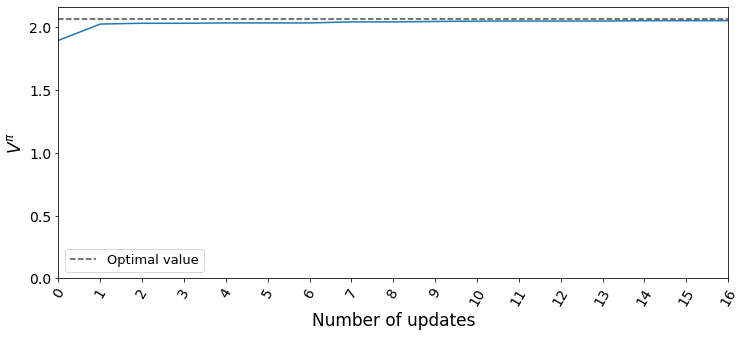

In [63]:
plt.figure(figsize=(12, 5))
plt.plot(root_values)
plt.axhline(v_full, linestyle='--', color='k', alpha=0.7, label='Optimal value')
plt.ylabel(r'$V^{\pi}$', fontsize=17)
plt.xlabel('Number of updates', fontsize=17)
plt.xticks(range(len(root_values)), range(len(root_values)), fontsize=14, rotation=60)
plt.yticks([0, 0.5, 1, 1.5, 2], fontsize=14)

plt.xlim(0, len(qval_history)-1)
plt.ylim(0, v_full+0.1)
plt.legend(prop={'size':13})
# plt.savefig(os.path.join(save_path, 'root_values.svg'), transparent=True)

In [61]:
for idx, val in enumerate(root_values):
    print(idx+1, val)

1 1.8949901600877392e+00
2 2.0246747716436713
3 2.030869377206004
4 2.03087223391301
5 2.0335535994287075
6 2.0335694370106676
7 2.033569539981739
8 2.041942064129938
9 2.0419420762498284
10 2.0451392115566116
11 2.048329658581925
12 2.0484364370726644
13 2.048436710560524
14 2.048436713042739
15 2.05183035430565
16 2.051840600650682
17 2.051840600922613
18 2.051840747993298
19 2.051840767027102
20 2.051840767849081
21 2.051840769530865
22 2.0518407695375585
23 2.0518407695398087
24 2.051840769539839
25 2.0518407695480363
26 2.0518407695526326
27 2.0518407695570318
28 2.051840769557088
29 2.051840769557089
30 2.0518407695576584
31 2.05184076955766
32 2.05184076955766
33 2.05184076955766
34 2.05184076955766
35 2.05184076955766
36 2.05184076955766
